This procedure was used to measure the step size in z on the OpenFlexure Microscope. Five precision-thickness coverslips were coloured using a whiteboard pen and stacked on top of the objective. Using the known gap between these planes, and the scipy find_peaks function, the distance in steps between these peaks were found. These differences were corrected to account for the refractive index of the glass (factor of 1.5), and averaged to give a distance per step of 50 nanometers. Errors from the width of the peaks and uncertainty in thickness were combined to give an uncertainty of +/- 2 nanometers

In [1]:
# Standard imports, plus the microscope client to control the OFM

import numpy as np
import openflexure_microscope_client
from scipy.signal import find_peaks
from matplotlib import pyplot as plt

In [2]:
# Connect to the relevant microscope

microscope = openflexure_microscope_client.MicroscopeClient("100.68.82.119")

In [3]:
# Takes the output of a move_and_measure sweep ('jpeg_times', 'jpeg_sizes', 'stage_times' and 'stage_positions') and interpolates to output heights and corresponding sizes
# Backlash may cause the objective movement to begin later than desired; start_index is the number of measurements from the start to remove
# (ie, 5 means consider the 6th measurement and later)

def unpack(scan_data, start_index):
    jpeg_times = scan_data['jpeg_times']
    jpeg_sizes = scan_data['jpeg_sizes']
    jpeg_sizes_MB = [x / 10**3 for x in jpeg_sizes]
    stage_times = scan_data['stage_times']
    stage_positions = scan_data['stage_positions']
    stage_height = [pos[2] for pos in stage_positions]

    jpeg_heights = np.interp(jpeg_times,stage_times,stage_height)

    return jpeg_heights[start_index:], jpeg_sizes_MB[start_index:]

In [65]:
# Set up the lists to be populated

all_heights = []
all_sizes = []

# Loop to repeat the measurements
for i in range(20):
    
    # Starting below the lowest plane, move up a small amount to eliminate backlash, then measure the JPEG size (image sharpness) over range dz
    microscope.move_rel((0,0,300))
    data = microscope.move_and_measure({'dz':20000})

    # Interpret and store the heights and sizes for that sweep
    heights, sizes = unpack(data, 5)
    all_heights.append(heights)
    all_sizes.append(sizes)

    # Repeat in the opposite direction, to limit the effects of asymetric movement or imaging
    microscope.move_rel((0,0,-300))
    data = microscope.move_and_measure({'dz':-20000})

    heights, sizes = unpack(data, 5)
    all_heights.append(heights)
    all_sizes.append(sizes)

# Save the heights and sizes of each sweep

np.save('z_data.npy', [all_heights, all_sizes], allow_pickle=True)

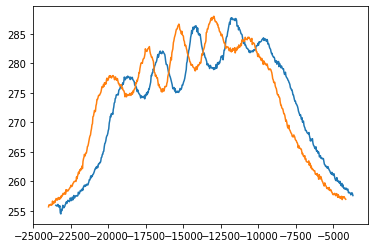

In [6]:
# Reload the heights and sizes, and plot the first upward and downward sweep to verify the appearance

all_data = np.load('z_data.npy', allow_pickle=True)

heights = all_data[0]
sizes = all_data[1]

plt.plot(heights[0],sizes[0])
plt.plot(heights[1],sizes[1])
plt.show()

In [7]:
peaks = []
step_size = []

for i in range(len(heights)):
    
    # Find the peaks in the measurement. Prominence set to reliably identify only the peaks corresponding to ink between coverslips,
    # but this can be ensured later
    indexes,_ = find_peaks(sizes[i], prominence=1)

    sweep_peaks = (heights[i][indexes])    
    peaks.append(sweep_peaks)

    # Find the distance between each subsequent peak in steps, then find the step size that corresponds to this distance
    # 1.5 is a correction factor for the n of glass affecting the measured distance, and 170 nm is the given thickness of a coverslip
    step_size.append([170 * 1000 / (1.5*int(x)) for x in (np.diff(np.sort(sweep_peaks)))])


In [8]:
# Delete the sweeps that have more than 4 distances corresponding to the 5 interfaces between coverslips
to_delete = []

for i in range(len(step_size)):
    if len(step_size[i]) > 4:
        to_delete.append(i)

step_size = np.delete(step_size, to_delete, axis = 0)

step_size=np.array([np.array(xi) for xi in step_size])

c:\Users\jakna\Source\z_dist_measure\.venv\lib\site-packages\numpy\lib\function_base.py:4454: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


[47.2496074  50.86699074 50.6208908  51.49376939]
50.05781458139701
4.073848186372546


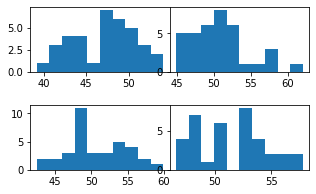

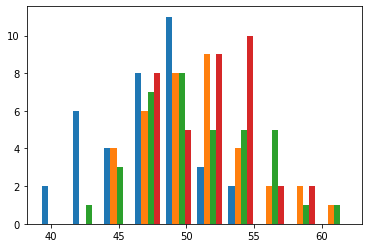

In [9]:
# Print the average step size for each coverslip spacing, the average step size overall, and the standard deviation on the step size

print(np.mean(step_size, axis=0))
print(np.mean(step_size))
print(np.std(step_size))

# Plot histograms of each step size for each coverslip gap, to inspect that none appear skewed or biased

fig, axs = plt.subplots(2,2, figsize=(5, 3), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()

for i in range(4):
    axs[i].hist(step_size[:,i])
plt.show()

plt.hist(step_size)
plt.show()

In [10]:
# Calculate the percentage uncertainty based on the standard deviation from the mean

p_uncert_peaks = (np.std(step_size) / np.sqrt(4*len(step_size))) / np.mean(step_size)

# The percentage uncertainty in the size of the coverslips: 170 +/- 5 nm according to the distributor

p_uncert_thickness = 5 / 170

# Other sources estimated as negligible - overall percent uncertainty is the combination of the above

p_uncert_tot = np.sqrt(p_uncert_peaks**2 + p_uncert_thickness**2)

print("Average step size is {:0.2f}+/-{:0.2f} nanometers".format(np.mean(step_size),np.mean(step_size)*(p_uncert_tot)))

Average step size is 50.06+/-1.51 nanometers
